# Neural Network for Binary Risk Classification

## 1. Data Preprocessing & Embedding Preparation

Neural Networks learn best when numerical features are scaled (normalized) and categorical features are fed into **Embedding Layers**.

**Our Pipeline:**
1.  **Numerical Features:** We use `StandardScaler` to force inputs (like `AnnualEarnings`) into a small range (mean 0, std 1). This prevents exploding gradients.
2.  **Categorical Features:** We use **Label Encoding** (converting strings to integers `0, 1, 2...`). 
    * *Why?* We will feed these integers into an Embedding Layer in the next step, allowing the model to learn dense vector representations for each category.
3.  **Target:** We isolate `RiskFlag`. Since this is binary classification, our target is a single vector of 0s and 1s.
4.  **Validation Split:** We set aside 20% of the training data *now* so we can use it to monitor the neural network's learning curve later.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import os
from pathlib import Path

# --- Configuration ---
# 1. Categorical Features (To be Label Encoded for Embeddings)
CAT_COLS = ['QualificationLevel', 'WorkCategory', 'RelationshipStatus', 
            'OwnsProperty', 'FamilyObligation', 'FundUseCase', 'JointApplicant']

# 2. Numerical Features (To be Scaled)
NUM_COLS = ['ApplicantYears', 'AnnualEarnings', 'RequestedSum', 'TrustMetric', 
            'WorkDuration', 'ActiveAccounts', 'OfferRate', 'RepayPeriod', 'DebtFactor']

def preprocess_for_nn(df, is_train=True, encoders=None):
    df = df.copy()
    
    # 1. Separation
    target = None
    if 'RiskFlag' in df.columns:
        target = df['RiskFlag'].values
        df = df.drop(columns=['RiskFlag'])
    
    if 'ProfileID' in df.columns:
        df = df.drop(columns=['ProfileID'])
        
    # Initialize storage for encoders if training
    if is_train:
        encoders = {
            'scaler': StandardScaler(),
            'label_encoders': {}
        }
    
    # 2. Scale Numerical Columns
    if is_train:
        df[NUM_COLS] = encoders['scaler'].fit_transform(df[NUM_COLS])
    else:
        df[NUM_COLS] = encoders['scaler'].transform(df[NUM_COLS])
        
    # 3. Label Encode Categorical Columns
    for col in CAT_COLS:
        df[col] = df[col].astype(str) # Handle potential mixed types
        
        if is_train:
            le = LabelEncoder()
            # Fit on unique values + 'Unknown' for safety
            unique_vals = list(df[col].unique()) + ['Unknown']
            le.fit(unique_vals)
            encoders['label_encoders'][col] = le
            df[col] = le.transform(df[col])
        else:
            le = encoders['label_encoders'][col]
            # Map unseen labels to 'Unknown'
            df[col] = df[col].map(lambda s: s if s in le.classes_ else 'Unknown')
            df[col] = le.transform(df[col])
            
    return df, target, encoders

# --- Load Data (Placeholder) ---
# Load your data here
dataset_dir = Path().cwd().parent / "datasets" / "preprocessed"
train = pd.read_csv(dataset_dir / "train_preprocessed.csv")
test = pd.read_csv(dataset_dir / "test_preprocessed.csv")

# --- Apply Preprocessing ---
# 1. Process Train
X_processed, y_processed, encoders = preprocess_for_nn(train, is_train=True)

# 2. Create Validation Split (Essential for NN Hyperparameter Tuning)
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y_processed, test_size=0.2, random_state=42, stratify=y_processed
)

print(f"Train Shape: {X_train.shape}")
print(f"Val Shape:   {X_val.shape}")
X_train.head()

Train Shape: (163421, 16)
Val Shape:   (40856, 16)


,ApplicantYears,AnnualEarnings,RequestedSum,TrustMetric,WorkDuration,ActiveAccounts,OfferRate,RepayPeriod,DebtFactor,QualificationLevel,WorkCategory,RelationshipStatus,OwnsProperty,FamilyObligation,FundUseCase,JointApplicant
107038,-0.766204,-0.314521,1.451876,1.579366,-0.187860,-1.344869,1.543367,1.415720,-1.388309,3,1,2,0,0,2,0
97600,1.434507,-0.657328,-0.570017,-0.126359,-0.043541,-0.449530,0.836621,-1.417010,-0.435570,1,2,2,0,0,2,0
6929,1.701260,1.088000,-1.014136,-0.101182,-0.938318,-0.449530,-1.628703,0.707538,-1.345003,3,1,2,0,0,0,0
89894,1.167755,-0.963679,-1.408421,1.654896,-1.457866,0.445809,-1.328826,-0.708827,-0.045813,0,0,0,0,2,1,2
69819,-1.166333,-0.510275,1.688105,-1.284490,1.255329,-0.449530,1.516243,0.707538,-1.561534,0,2,2,2,2,1,2


## 2. Neural Network Architecture & Hyperparameter Tuning

We use the Keras **Functional API** to build a custom architecture:
1.  **Embedding Branch:** Each categorical feature (e.g., `WorkCategory`) gets its own Input and Embedding Layer. This allows the network to learn a dense vector for "Self-Employed" vs "Salaried", capturing semantic relationships.
2.  **Numerical Branch:** Numerical features are fed directly into a Dense layer.
3.  **Concatenation:** The outputs of both branches are merged and passed through deep Dense layers.

**Hyperparameter Search:**
Instead of guessing, we loop through combinations of:
* **Units:** Capacity of the network (e.g., 64 vs 128 neurons).
* **Dropout:** Regularization strength (to prevent overfitting).
* **Learning Rate:** Step size for the optimizer.

We use **EarlyStopping** to automatically halt training if the validation loss stops improving, saving time.

Starting Neural Network Grid Search...

Testing: {'units': 64, 'dropout': 0.3, 'lr': 0.001}
  -> Best Val Loss: 0.3124

Testing: {'units': 128, 'dropout': 0.3, 'lr': 0.001}
  -> Best Val Loss: 0.3125

Testing: {'units': 128, 'dropout': 0.5, 'lr': 0.0005}
  -> Best Val Loss: 0.3121

WINNER: {'units': 128, 'dropout': 0.5, 'lr': 0.0005} with Val Loss: 0.3121


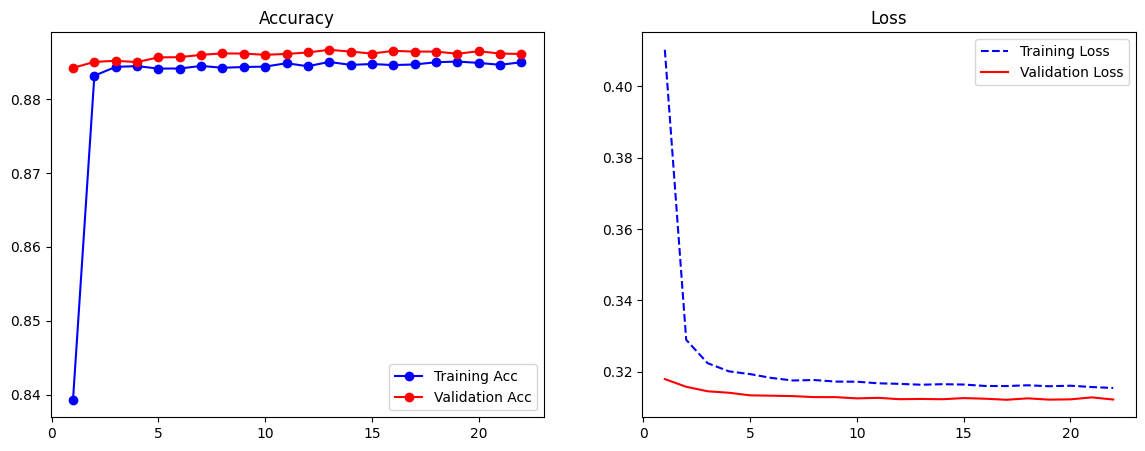

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# --- 1. Data Preparation for Functional API ---
# Keras requires a list of inputs: [Cat1_Array, Cat2_Array, ..., CatN_Array, Numerical_Matrix]
def get_keras_inputs(df, cat_cols, num_cols):
    inputs = []
    # 1. Categorical Inputs (One array per column)
    for col in cat_cols:
        inputs.append(df[col].values)
    
    # 2. Numerical Inputs (One matrix for all)
    inputs.append(df[num_cols].values)
    return inputs

# Format Training and Validation data
# (Assuming X_train, X_val, y_train, y_val exist from Step 1's train_test_split)
X_train_inputs = get_keras_inputs(X_train, CAT_COLS, NUM_COLS)
X_val_inputs = get_keras_inputs(X_val, CAT_COLS, NUM_COLS)

# --- 2. Model Builder Function ---
def build_model(hp_units, hp_dropout, hp_lr):
    inputs_list = []
    embeddings = []
    
    # A. Embedding Branch
    for col in CAT_COLS:
        # Input for single integer
        input_cat = layers.Input(shape=(1,), name=f"in_{col}")
        inputs_list.append(input_cat)
        
        # Embedding Dimension Rule of Thumb: min(50, unique/2)
        n_unique = X_train[col].nunique()
        embed_dim = min(50, (n_unique // 2) + 1)
        
        # Layer
        emb = layers.Embedding(input_dim=n_unique + 1, output_dim=embed_dim, name=f"emb_{col}")(input_cat)
        emb = layers.Flatten()(emb)
        embeddings.append(emb)
        
    # B. Numerical Branch
    input_num = layers.Input(shape=(len(NUM_COLS),), name="in_numerics")
    inputs_list.append(input_num)
    
    # C. Merge
    x = layers.Concatenate()(embeddings + [input_num])
    
    # D. Dense Layers
    x = layers.Dense(hp_units, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp_dropout)(x)
    
    x = layers.Dense(hp_units // 2, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp_dropout)(x)
    
    # Output (Binary Classification -> Sigmoid)
    output = layers.Dense(1, activation='sigmoid', name="output")(x)
    
    # Compile
    model = models.Model(inputs=inputs_list, outputs=output)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp_lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 3. Hyperparameter Tuning Loop ---
param_grid = [
    {'units': 64, 'dropout': 0.3, 'lr': 0.001},
    {'units': 128, 'dropout': 0.3, 'lr': 0.001},
    {'units': 128, 'dropout': 0.5, 'lr': 0.0005}, # High regularization
]

best_val_loss = float('inf')
best_model = None
best_history = None
best_params = {}

print("Starting Neural Network Grid Search...")

for params in param_grid:
    print(f"\nTesting: {params}")
    
    model = build_model(params['units'], params['dropout'], params['lr'])
    
    es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train_inputs, y_train,
        validation_data=(X_val_inputs, y_val),
        epochs=30,
        batch_size=64,
        callbacks=[es],
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    print(f"  -> Best Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_history = history
        best_params = params

print(f"\nWINNER: {best_params} with Val Loss: {best_val_loss:.4f}")

# --- 4. Plot Training History ---
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(epochs, acc, 'bo-', label='Training Acc')
    ax1.plot(epochs, val_acc, 'ro-', label='Validation Acc')
    ax1.set_title('Accuracy')
    ax1.legend()
    
    ax2.plot(epochs, loss, 'b--', label='Training Loss')
    ax2.plot(epochs, val_loss, 'r-', label='Validation Loss')
    ax2.set_title('Loss')
    ax2.legend()
    plt.show()

plot_history(best_history)

## 3. Model Evaluation

We evaluate the `best_model` on the **Validation Set**. This tells us how well the model generalizes to new data.

**Key Metrics:**
1.  **Confusion Matrix:** Shows us exactly where the model makes mistakes.
    * *False Negatives (FN):* High Risk applicants we missed (Dangerous!).
    * *False Positives (FP):* Safe applicants we flagged as risky (Annoying).
2.  **ROC Curve & AUC:** Measures the model's ability to distinguish between classes. An AUC of 0.5 is random guessing; 1.0 is perfect.
3.  **F1-Score:** The harmonic mean of precision and recall, useful if the classes are imbalanced.

1277/1277 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

=== Model Performance (Validation Set) ===
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     36105
           1       0.61      0.07      0.12      4751

    accuracy                           0.89     40856
   macro avg       0.75      0.53      0.53     40856
weighted avg       0.86      0.89      0.84     40856



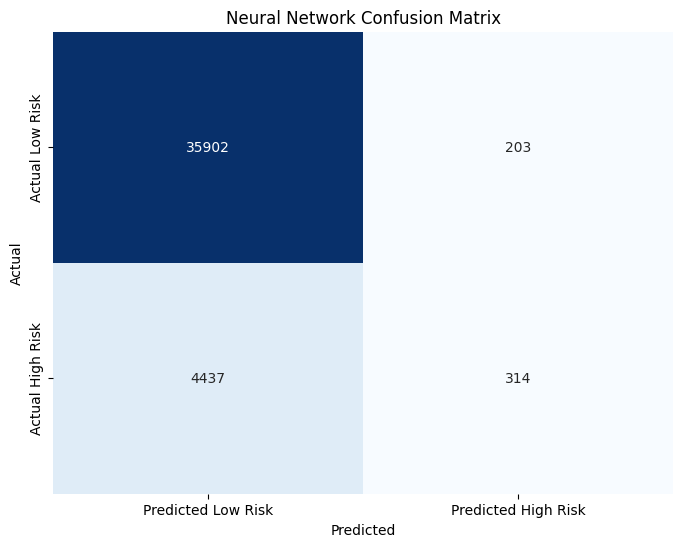

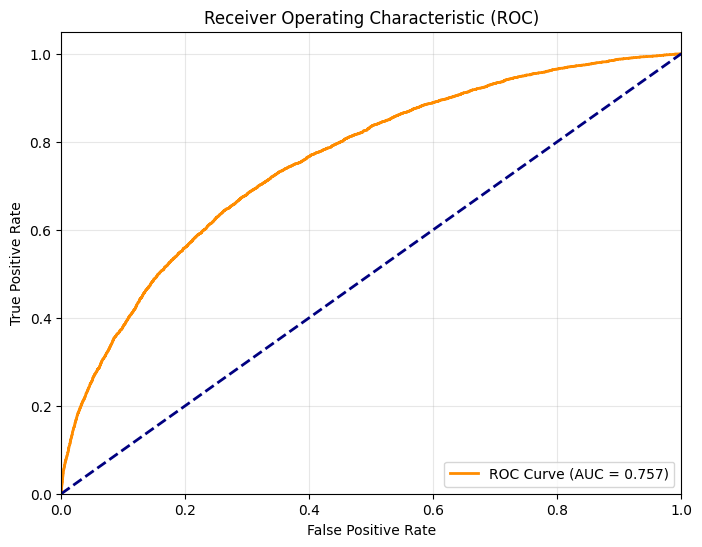

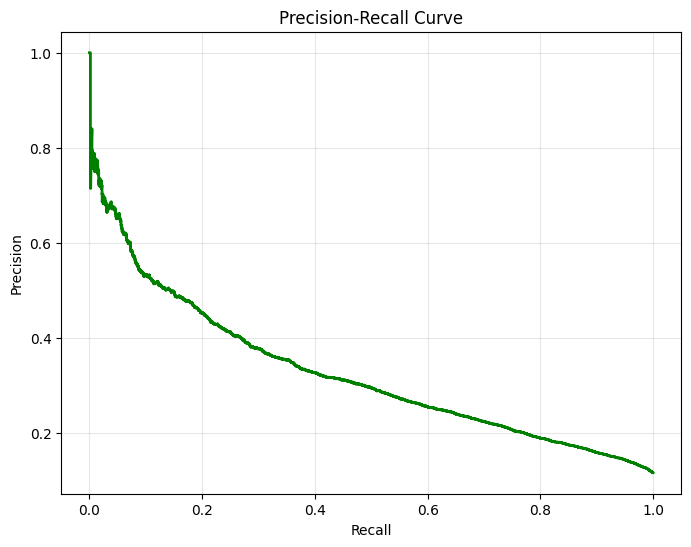

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# --- 1. Make Predictions on Validation Set ---
# The model outputs a probability between 0 and 1
y_pred_prob = best_model.predict(X_val_inputs)

# Convert probability to class (0 or 1) using a threshold of 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# --- 2. Classification Report ---
print("\n=== Model Performance (Validation Set) ===")
print(classification_report(y_val, y_pred))

# --- 3. Confusion Matrix Visualization ---
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Low Risk', 'Predicted High Risk'],
            yticklabels=['Actual Low Risk', 'Actual High Risk'])
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- 4. ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# --- 5. Precision-Recall Curve (Optional but good for imbalanced data) ---
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.show()

## 4. Retraining on Full Data & Submission

We found the best architecture using the Validation Set. Now, we deploy it.

**The Workflow:**
1.  **Retrain:** We build a fresh model using the winning parameters (`best_params`) and train it on the **full training set** (no validation split). This gives the model maximum data to learn from.
2.  **Process Test Data:** We apply the *exact same* Label Encoders and Scalers used on the training data to the Test data.
3.  **Predict:** We generate probabilities for the test set.
4.  **Thresholding:** Since this is binary classification, the model outputs a number between 0 and 1. We apply a threshold (0.5) to convert this into a hard `RiskFlag` (0 or 1).

In [4]:
# --- 1. Prepare Full Training Data ---
# We use the full X_processed and y_processed from Step 1 (before the train/val split)
# If variables were lost, ensure you run Step 1's preprocessing on the full 'train' df again.
full_train_inputs = get_keras_inputs(X_processed, CAT_COLS, NUM_COLS)
full_train_labels = y_processed

print(f"Retraining on full dataset: {len(full_train_labels)} samples")
print(f"Best Params: {best_params}")

# --- 2. Build & Train Final Model ---
# Re-instantiate the model structure with the winner params
final_model = build_model(
    hp_units=best_params['units'],
    hp_dropout=best_params['dropout'],
    hp_lr=best_params['lr']
)

# Fit on ALL data
# We train for a fixed number of epochs (e.g., 20-30) since we can't use EarlyStopping without a val set.
# Ideally, you use the epoch number where val_loss stopped improving in Step 2.
final_model.fit(
    full_train_inputs, 
    full_train_labels,
    epochs=25, 
    batch_size=64,
    verbose=1
)

# --- 3. Process Test Data ---
# Apply the encoders fitted on Train to Test
# Note: 'test' df should be loaded from the CSV
X_test_processed, _, _ = preprocess_for_nn(test, is_train=False, encoders=encoders)

# Format for Keras
test_inputs = get_keras_inputs(X_test_processed, CAT_COLS, NUM_COLS)

# --- 4. Generate Predictions ---
print("\nPredicting on Test Set...")
test_probs = final_model.predict(test_inputs)

# Thresholding (0.5 is standard, but you can tune this based on Precision-Recall needs)
test_preds = (test_probs > 0.5).astype(int).flatten()

# --- 5. Create Submission CSV ---
submission = pd.DataFrame({
    'ProfileID': test['ProfileID'],
    'RiskFlag': test_preds
})

submission.to_csv("submission_supervised_neural_network.csv", index=False)
print("Saved: submission_supervised_neural_network.csv")

# Quick check of class balance in prediction
print("\nPredicted Class Distribution:")
print(submission['RiskFlag'].value_counts(normalize=True))

Retraining on full dataset: 204277 samples
Best Params: {'units': 128, 'dropout': 0.5, 'lr': 0.0005}
Epoch 1/25
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8488 - loss: 0.3920
Epoch 2/25
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8833 - loss: 0.3254
Epoch 3/25
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8841 - loss: 0.3208
Epoch 4/25
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8842 - loss: 0.3194
Epoch 5/25
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8848 - loss: 0.3182
Epoch 6/25
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8845 - loss: 0.3174
Epoch 7/25
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8845 - loss: 0.3172
Epoch 8/25
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8847 - loss: 0.3168
Epoch 9/25
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8848 - loss: 0.3165
Epoch 10/25
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8847 - loss: 0.3165
Epoch 11/25
3192/3